## Section 1: **l-alanine** geometry optimization

In the following cells, we will learn how to download a geometry of a molecule (in this case l-alanine) from pubchem, visualise its geometry, and check its rotational constants. Then, we will optimize its structure to a minimum
with quantum chemistry, and learn how to save its absolute energy, rotational constants, and dipole moments.

### Step 1.0: import python modules

In [1]:
import psi4                        # for quantum chemistry
import py3Dmol as p3d              # for 3D visualisation
import qcelemental as qcel         # for physical constants
from rdkit import Chem             # for 2D visualisation
from openbabel import openbabel    # for format conversions

### Step 1.1: getting l-alanine from pubchem:

This is fairly easy. We tell Psi4 to search for a geometry of `<molecule>` on pubchem using the `psi4.geometry("pubchem:<molecule>")` syntax. This function returns a special `molecule` object, which contains the geometry of the molecule (atomic positions in cartesian coordinates), information about the molecular charge, multiplicity, and derived data such as rotational constants and the distance matrix between all atoms. As we want to use the geometry later, we save it into a variable called `l_alanine`:

In [2]:
l_alanine = psi4.geometry("pubchem:l-alanine")

	Searching PubChem database for l-alanine (single best match returned)
	Found 1 result(s)


### Step 1.2: visualising the molecule:
#### Step 1.2.1: 3D representation:
Here we define a function `drawMol3D()` that takes one argument, a molecule geometry in the Psi4 format. You can adjust the width and height of the generated figure by adjusting the parameters. The function first generates a `XYZ file` representation of the molecule, and draws it using py3Dmol.

We can re-use this function by calling `drawMol3D(<saved molecule>)`, or in the case of l-alanine, `drawMol3D(l_alanine)`. In the example below, we save this "view" into the variable `fig`, so that we can generate a `png` figure for our lab report. You can rotate the figure by dragging the mouse, and zoom by using the scroll wheel.

In [3]:
def drawMol3D(mol, width = 250, height = 200):
    xyz = mol.save_string_xyz_file() 
    view = p3d.view(width = width, height = height)
    view.addModel(xyz, "xyz")
    view.setStyle({'stick':{}})
    view.zoomTo()
    return view
fig = drawMol3D(l_alanine)
fig.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Once you are happy with how the molecule looks in the box above, run the cell below, and then you can `right click -> save as` the figure.

In [4]:
fig.png()

#### Step 1.2.2: 2D stereochemical representation / diagram:
For this visualisation, we use two very powerful packages: OpenBabel and RDkit. First, we need to convert the Psi4 molecule into a SMILES representation. We can generate the XYZ coordinates directly from the Psi4 format. Then we need to convert that to SMILES using openbabel. Then, we can use these SMILES to generate a drawing that displays stereochemistry using RDkit. 

The generated SMILES are: OC(=O)[C@@H](N)C	



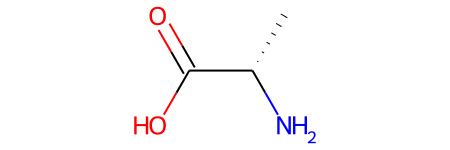

In [5]:
def drawMol2D(mol, width=100, height=100):
    xyz = mol.save_string_xyz_file()
    obc = openbabel.OBConversion()
    obm = openbabel.OBMol()
    obc.SetInAndOutFormats("xyz", "smi")
    obc.ReadString(obm, xyz)
    smi = obc.WriteString(obm)
    print("The generated SMILES are: " + smi)
    m = Chem.MolFromSmiles(smi)
    Chem.Kekulize(m)
    return(m)

drawMol2D(l_alanine)

A further example with a few randomly chosen molecules is shown below.

	Searching PubChem database for l-glucose (single best match returned)
	Found 1 result(s)
The generated SMILES are: O[C@H]([C@@H](O)[C@H](O)C=O)[C@@H](O)CO	

	Searching PubChem database for butadiene (single best match returned)
	Found 1 result(s)
The generated SMILES are: C(=C)C=C	

	Searching PubChem database for nicotine (single best match returned)
	Found 1 result(s)
The generated SMILES are: N1([C@@H](CCC1)c1cccnc1)C	

	Searching PubChem database for l-tyrosine (single best match returned)
	Found 1 result(s)
The generated SMILES are: OC(=O)[C@@H](N)Cc1ccc(O)cc1	

	Searching PubChem database for d-alanine (single best match returned)
	Found 1 result(s)
The generated SMILES are: OC(=O)[C@H](N)C	

	Searching PubChem database for l-alanine (single best match returned)
	Found 1 result(s)
The generated SMILES are: OC(=O)[C@@H](N)C	



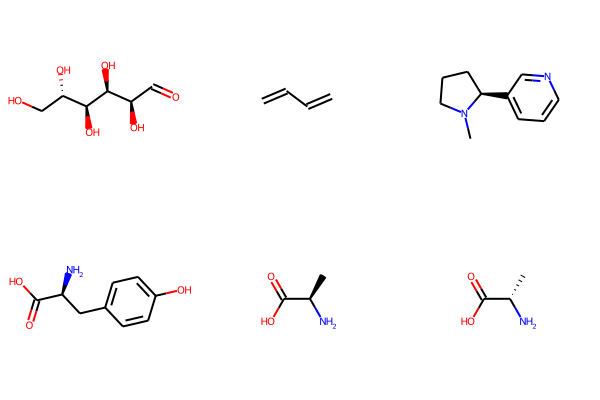

In [6]:
names = ["l-glucose", "butadiene", "nicotine", "l-tyrosine", "d-alanine", "l-alanine"]
pics = []
for name in names:
    mol = psi4.geometry(f"pubchem:{name}")
    pics.append(drawMol2D(mol))
Chem.Draw.MolsToGridImage(pics)

### Step 1.3: Accessing rotational constants
We can also check the rotational constants of the original molecule from pubchem. The function `<molecule>.rotational_constants().np` returns the rotational constants as a wavenumber ($\lambda$) in 
cm<sup>-1</sup>. For the rest of this module, we'd prefer to use rotational constants as frequencies ($f$) 
in MHz, therefore we need to convert between the two using:

\begin{align}
f = c \lambda
\end{align}

We can define another helper function to aid us. The module `qcelemental.constants` contains all important physical constants, and we can access the speed of light ($c$, in m/s) as `qcel.constants.c`. We need to multiply that by 100 (to convert from m/s to cm/s), and then convert from Hz (which is s <sup>-1</sup>) to MHz.

In [7]:
def getRotConstMHz(mol):
    incm = mol.rotational_constants().np
    inHz = [i * qcel.constants.c * 100 for i in incm]
    inMHz = [i/1e6 for i in inHz]
    return(inMHz)

pubchem_rot_consts = getRotConstMHz(l_alanine)
print(pubchem_rot_consts)

[5108.350381344177, 3206.106037007035, 2215.7842244027784]


We unfortunately cannot check the dipole moment of the pubchem version, as for that we need the electron density. We will look at that using the optimized version of the molecule.

### Step 1.4: Optimizing the geometry with Psi4:
When we want to find the minimum energy conformation of any molecule, the process by
which we do that is called "geometry optimization". We will use the program Psi4 to do that, 
using a good but computationally cheap method: [PBEh-3c by Grimme et al.](https://doi.org/10.1063/1.4927476). This method is quite nice, as it includes modern corrections, but remains computationally inexpensive.

The pubchem geometry of l-alanine is close to the true minimum geometry, but each computational method is slightly different, so it makes sense to make sure we are at the minimum of that method. This is especially important as we are after the rotational constants.

In the next cell, we will optimize the l-alanine molecule stored in `l_alanine` using the PBEh-3c density functional. **This may take a few minutes, so do not panic.** The absolute energy of the optimized molecule will be saved into the variable `E` (in Hartrees), and the wavefunction $\psi$ of the optimized molecule into the `wfn` object. The new geometry can be accessed as `wfn.molecule()`.

Once finished, a message "Optimizer: Optimization complete!" will appear...

In [8]:
E, wfn = psi4.optimize("pbeh3c", mol=l_alanine, return_wfn=True)

Optimizer: Optimization complete!


### Step 1.5: Compare pubchem and optimized l-anilines:

In the cell below, we compare the original (from pubchem) and optimized 3D representations of l-aniline. Is there any perceptible difference?

In [9]:
print("pubchem version:")
drawMol3D(l_alanine).show()
print(getRotConstMHz(l_alanine))
print()
print("optimized version:")
drawMol3D(wfn.molecule()).show()
print(getRotConstMHz(wfn.molecule()))

pubchem version:


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

[5108.350381344177, 3206.106037007035, 2215.7842244027784]

optimized version:


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

[5110.955676652406, 3061.404930908405, 2364.47539323793]


As you see in the output above, there is a significant change in the rotational constants, especially along $b$ and $c$, even though visually the change is almost imperceptible.

### Step 1.6: Accessing dipole moments:
The dipole moments are stored in the wavefunction object `wfn`. We can access them using the `wfn.scalar_variable()` function as shown below:

In [10]:
dip_X = wfn.scalar_variable("SCF DIPOLE X")
dip_Y = wfn.scalar_variable("SCF DIPOLE Y")
dip_Z = wfn.scalar_variable("SCF DIPOLE Z")
print(f"Dipole moment along X = {dip_X:5.2f} Debye,\n"
      f"                    Y = {dip_Y:5.2f} Debye,\n"
      f"                    Z = {dip_Z:5.2f} Debye.")

Dipole moment along X = -0.84 Debye,
                    Y = -2.04 Debye,
                    Z = -0.07 Debye.


For a list of all scalar properties that are calculated and stored on the wavefunction object, we can use the `wfn.scalar_variables()` function. Of course, the wavefunction stores much more information about the molecule, including occupied/unoccupied orbitals and their energies.

In [11]:
wfn.scalar_variables()

{'2-BODY DISPERSION CORRECTION ENERGY': -0.00548704,
 'CURRENT DIPOLE X': -0.8395587030351533,
 'CURRENT DIPOLE Y': -2.0425906675038674,
 'CURRENT DIPOLE Z': -0.06753261541918026,
 'CURRENT ENERGY': -323.056674343852,
 'CURRENT REFERENCE ENERGY': -323.056674343852,
 'DFT FUNCTIONAL TOTAL ENERGY': -323.07719293925203,
 'DFT TOTAL ENERGY': -323.056674343852,
 'DFT VV10 ENERGY': 0.0,
 'DFT XC ENERGY': -25.118014025927945,
 'DISPERSION CORRECTION ENERGY': -0.00548704,
 'GRID ELECTRONS ALPHA': 23.999993705647203,
 'GRID ELECTRONS BETA': 23.999993705647203,
 'GRID ELECTRONS TOTAL': 47.999987411294406,
 'NUCLEAR REPULSION ENERGY': 250.6685594758974,
 'ONE-ELECTRON ENERGY': -937.2651455296864,
 'PBEH3C DISPERSION CORRECTION ENERGY': -0.00548704,
 'PCM POLARIZATION ENERGY': 0.0,
 'PE ENERGY': 0.0,
 'SCF DIPOLE X': -0.8395587030351533,
 'SCF DIPOLE Y': -2.0425906675038674,
 'SCF DIPOLE Z': -0.06753261541918026,
 'SCF ITERATION ENERGY': -323.056674343852,
 'SCF ITERATIONS': 7.0,
 'SCF TOTAL ENERG